# Review of 2018 Vaccine Adverse Event Reporting System 

## Introduction

##### The data set tracks VAERS, which is the Vaccine Adverse Event Reporting System for the year 2015. This information is obtained by the Centers for Disease Control and Prevention (CDC). 

##### The data set details include vaccine names, manufacturers, manufacturer’s lot numbers, vaccine doses, administration routes, and anatomical sites where the vaccine was administered. 

##### Additionally, the primary information data provides age, sex, symptoms reported, and the following adverse events outcomes: Died, Life Threatening, ER visit, Hospitalized, Days Hospitalized, Disabled, Recovered, Vaccination Data, Onset Date, Onset Interval, Other Medications, Current Illnesses, Prior Vaccination and Condition History. 

## Purpose

##### Vaccination is facing increasing public health pressures and it is important to note if the drug formulations themselves are becoming more advanced through new administration techniques that could be more direct and less potentially prone to adverse events. Additionally, there is increased public debate regarding the appropriate age of vaccination and what combinations of vaccinations to be given at a time. 

##### The VAERS form strives to collect data across a broad spectrum of variables, however, it is biased in the sense that vaccines where no adverse events occurred are not recorded by the reporting system, or at least that data is not available in the 2018 sample set. 

##### With any incomplete date set, especially one that has the potential to influence public health policy and that has the power to sway decision making in the regulatory sphere it is important to have clear transparency in the data you are utilizing to guide your predictive models and to state its limitations within the analysis.

##### It is further important to make an inference on how the outcomes can change with the introduction of missing variables and the impact that would have on the model. In this particular scenario, it would be necessary to understand why the surveys were not collected on no adverse events and address if it would play a significant role on the questions posed. Based on literature review on adverse event reporting within the clinical setting, the nature of the way the data is collected is misleading. The survey is only available when an event occurs that signals a negative adverse event. The system itself is not set up to collect all vaccination events and thus record all outcomes, both positive and negative. This will be critical to note in the analysis and in the recommendations made moving forward.


In [28]:
import pandas as pd
import seaborn as sns
import pdb

## Datasets

##### df_vax denotes half of the vaccination data collected (which includes information about the vaccination themselves
##### df_sym denotes the data surrounding the adverse events 

In [29]:
df_vax = pd.read_csv('./2019VAERSVAX.csv')

In [30]:
df_sym = pd.read_csv('./2019VAERSDATA.csv', encoding='cp1252')

In [31]:
df_sym.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,794156,1/1/19,NaN,69.0,69.0,NaN,F,NaN,"Severe pain Lt. shoulder area, very localized ...",NaN,...,none,none,NaN,NaN,2,1/1/19,NaN,Y,NaN,tetracycline
1,794157,1/1/19,IL,68.0,68.0,NaN,F,NaN,"Much joint pain/aching, lack of energy, listle...",NaN,...,None,Hypothryoidism,Arm soreness at site of injection,NaN,2,1/1/19,NaN,NaN,NaN,None
2,794158,1/1/19,MA,62.0,62.0,NaN,F,NaN,"Headache, Fever, Chills, Body Aches, Nausea la...",NaN,...,None,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,None
3,794159,1/1/19,UT,5.0,5.0,NaN,M,NaN,"Site is swollen, red and warm to the touch. Pa...",NaN,...,Small red spot on his cheek at time of visit.,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,Amoxicillin
4,794160,1/1/19,TX,79.0,79.0,NaN,F,NaN,"FLU LIKE: CHILLS ACHE ALL OVER; STRONG PAIN, W...",NaN,...,SINUSITIS; ATHROSCLEROSIS; DIABETES; HYPERCHOL...,SAME AS ITEM 11 ABOVE,NaN,NaN,2,1/1/19,NaN,Y,Y,ACE INHIBITORS


## Merged Datasets

In [32]:
df_vax.merge(df_sym, left_on='VAERS_ID' , right_on='VAERS_ID')
df_vax.head()

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,794156,FLU4,GLAXOSMITHKLINE BIOLOGICALS,JZ3B7,UNK,IM,LA,INFLUENZA (SEASONAL) (FLUARIX QUADRIVALENT)
1,794157,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX)
2,794158,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX)
3,794159,DTAPIPV,GLAXOSMITHKLINE BIOLOGICALS,G9P35,1,IM,LL,DTAP + IPV (KINRIX)
4,794159,MMRV,MERCK & CO. INC.,R015744,1,SC,LL,MEASLES + MUMPS + RUBELLA + VARICELLA (PROQUAD)


In [33]:
finaldata = df_vax.merge(df_sym, left_on='VAERS_ID' , right_on='VAERS_ID')

## Name of Vaccine Providers (Pharmaceuticals)

In [34]:
finaldata['VAX_MANU'].value_counts()

GLAXOSMITHKLINE BIOLOGICALS          2596
MERCK & CO. INC.                     1746
SANOFI PASTEUR                        976
SEQIRUS, INC.                         710
PFIZER\WYETH                          358
UNKNOWN MANUFACTURER                  323
NOVARTIS VACCINES AND DIAGNOSTICS     182
PROTEIN SCIENCES CORPORATION           31
CSL LIMITED                            21
EMERGENT BIOSOLUTIONS                  20
MEDIMMUNE VACCINES, INC.               14
BERNA BIOTECH, LTD.                    10
MASS. PUB HLTH BIOL LAB                 6
INTERCELL AG                            6
DYNAVAX TECHNOLOGIES CORPORATION        5
PAXVAX                                  3
TEVA PHARMACEUTICALS                    2
MICHIGAN DEPT PUB HLTH                  1
Name: VAX_MANU, dtype: int64

##### Missing data is present in the type of manufacturers. This is a consequence on the collection survey method.

In [35]:
finaldata['VAX_NAME'].value_counts()

ZOSTER (SHINGRIX)                                          1847
INFLUENZA (SEASONAL) (FLUCELVAX QUADRIVALENT)               617
INFLUENZA (SEASONAL) (FLUZONE QUADRIVALENT)                 319
ZOSTER (ZOSTAVAX)                                           319
PNEUMO (PREVNAR13)                                          299
PNEUMO (PNEUMOVAX)                                          274
HPV (GARDASIL 9)                                            248
MEASLES + MUMPS + RUBELLA (MMR II)                          199
VARICELLA (VARIVAX)                                         186
INFLUENZA (SEASONAL) (FLUARIX QUADRIVALENT)                 165
INFLUENZA (SEASONAL) (FLUZONE HIGH-DOSE)                    146
ROTAVIRUS (ROTATEQ)                                         132
INFLUENZA (SEASONAL) (NO BRAND NAME)                        129
TDAP (BOOSTRIX)                                             123
HEP A (VAQTA)                                               119
MEASLES + MUMPS + RUBELLA + VARICELLA (P

## Route of Administration 

##### __*IM*__: intramuscular injection (ex. tetnus, HepB, flu vaccine) --- delivered into muscle

##### __*UN*__: unknown site injection

##### __*SYR*__: syringe (undisclosed if intramuscular or subcutanous)

##### __*SC*__: subcutanous injection (ex. MMR, Varicella) ---- in the fat layer underneath skin

##### __*PO*__: per oral (medication) 

##### __*OT*__: other

##### __*IN*__: intranasal (flu vaccine)

##### __*ID*__: intradermal (ex. TB test) --- skin layer underneath epidermis, upper layer


In [36]:
finaldata['VAX_ROUTE'].value_counts()

IM     3584
UN     1757
SYR     679
SC      323
PO      106
OT       37
IN       15
ID       14
Name: VAX_ROUTE, dtype: int64

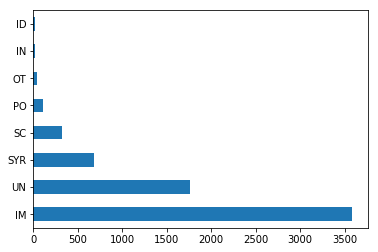

In [37]:
finaldata['VAX_ROUTE'].value_counts().plot('barh')

##### To note, the IM method of delivery is still the most common used in many vaccine type. Intranasal (non-invasive) is the lowerst, but there is a lot of information missing from the data. In addition, many of the standard vaccinations do not yet come in that formulation.

## Visualization of Datasets

Text(0, 0.5, 'Count')

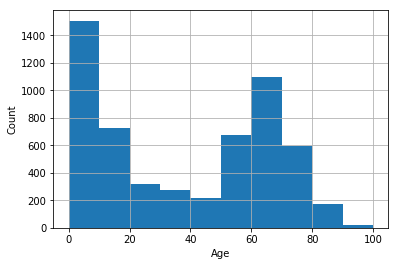

In [38]:
import matplotlib.pyplot as plt 
finaldata['AGE_YRS'].hist(bins=10)
plt.xlabel('Age')
plt.ylabel('Count')
#newdf = finaldata['AGE_YRS'].value_counts()
#range of age and histo

##### As can be visuablised above, the number of vaccines administered are higher in specific subsectors of the population, particulary higher for childer and young adults under 20, and for adults between 60 and 70. 

In [39]:
finaldata=finaldata.set_index('VAERS_ID')
finaldata.head()

,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME,RECVDATE,STATE,AGE_YRS,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
VAERS_ID,,,,,,,,,,,,,,,,,,,,,
794156,FLU4,GLAXOSMITHKLINE BIOLOGICALS,JZ3B7,UNK,IM,LA,INFLUENZA (SEASONAL) (FLUARIX QUADRIVALENT),1/1/19,NaN,69.0,...,none,none,NaN,NaN,2,1/1/19,NaN,Y,NaN,tetracycline
794157,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX),1/1/19,IL,68.0,...,None,Hypothryoidism,Arm soreness at site of injection,NaN,2,1/1/19,NaN,NaN,NaN,None
794158,VARZOS,GLAXOSMITHKLINE BIOLOGICALS,NaN,UNK,NaN,NaN,ZOSTER (SHINGRIX),1/1/19,MA,62.0,...,None,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,None
794159,DTAPIPV,GLAXOSMITHKLINE BIOLOGICALS,G9P35,1,IM,LL,DTAP + IPV (KINRIX),1/1/19,UT,5.0,...,Small red spot on his cheek at time of visit.,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,Amoxicillin
794159,MMRV,MERCK & CO. INC.,R015744,1,SC,LL,MEASLES + MUMPS + RUBELLA + VARICELLA (PROQUAD),1/1/19,UT,5.0,...,Small red spot on his cheek at time of visit.,None,NaN,NaN,2,1/1/19,NaN,NaN,NaN,Amoxicillin


## Selected categories of interest

In [40]:
selection=['VAX_MANU','VAX_ROUTE','VAX_SITE','VAX_NAME','AGE_YRS','ER_VISIT']
cutfinaldata=pd.DataFrame(finaldata,columns=selection)
cutfinaldata.head()

,VAX_MANU,VAX_ROUTE,VAX_SITE,VAX_NAME,AGE_YRS,ER_VISIT
VAERS_ID,,,,,,
794156,GLAXOSMITHKLINE BIOLOGICALS,IM,LA,INFLUENZA (SEASONAL) (FLUARIX QUADRIVALENT),69.0,NaN
794157,GLAXOSMITHKLINE BIOLOGICALS,NaN,NaN,ZOSTER (SHINGRIX),68.0,NaN
794158,GLAXOSMITHKLINE BIOLOGICALS,NaN,NaN,ZOSTER (SHINGRIX),62.0,NaN
794159,GLAXOSMITHKLINE BIOLOGICALS,IM,LL,DTAP + IPV (KINRIX),5.0,NaN
794159,MERCK & CO. INC.,SC,LL,MEASLES + MUMPS + RUBELLA + VARICELLA (PROQUAD),5.0,NaN


In [41]:
cutfinaldata.count()

VAX_MANU     7010
VAX_ROUTE    6515
VAX_SITE     6233
VAX_NAME     7010
AGE_YRS      5613
ER_VISIT       70
dtype: int64

ER visit (not collected or not needed) and no way it was reported 

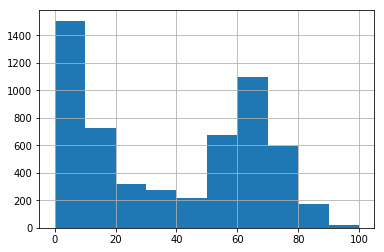

In [42]:
cutfinaldata['AGE_YRS'].hist(bins=10)

In [43]:
cutfinaldata.dtypes

VAX_MANU      object
VAX_ROUTE     object
VAX_SITE      object
VAX_NAME      object
AGE_YRS      float64
ER_VISIT      object
dtype: object

In [44]:
cutfinaldata['VAX_MANU']=cutfinaldata['VAX_MANU'].astype('category').cat.codes
cutfinaldata['VAX_ROUTE']=cutfinaldata['VAX_ROUTE'].astype('category').cat.codes
cutfinaldata['VAX_SITE']=cutfinaldata['VAX_SITE'].astype('category').cat.codes
cutfinaldata['VAX_NAME']=cutfinaldata['VAX_NAME'].astype('category').cat.codes
cutfinaldata['ER_VISIT']=cutfinaldata['ER_VISIT'].astype('category').cat.codes

In [45]:
cutfinaldata.dtypes

VAX_MANU        int8
VAX_ROUTE       int8
VAX_SITE        int8
VAX_NAME        int8
AGE_YRS      float64
ER_VISIT        int8
dtype: object

## Correlation Analysis

In [46]:
corr2=cutfinaldata.corr()
corr2.style.background_gradient(cmap='RdBu_r', axis=None).set_precision(3)
# 'coolwarm', RdBu_r', & 'BrBG' good color maps
#slight correlation between age and vax_name, which makes sense as many vaccines are given based on age type
#could show a stronger correlation if data is cleaner 

,VAX_MANU,VAX_ROUTE,VAX_SITE,VAX_NAME,AGE_YRS,ER_VISIT
VAX_MANU,1,0.0322,0.0471,-0.419,-0.282,0.00944
VAX_ROUTE,0.0322,1,0.455,0.0619,-0.111,0.0144
VAX_SITE,0.0471,0.455,1,-0.0653,-0.192,-0.00401
VAX_NAME,-0.419,0.0619,-0.0653,1,0.535,-0.0442
AGE_YRS,-0.282,-0.111,-0.192,0.535,1,-0.026
ER_VISIT,0.00944,0.0144,-0.00401,-0.0442,-0.026,1


##### As seen above, there is a slight correlation between age and vax_name, which makes sense as many vaccines are given based on age type. A stonger correlation could be shown if the data would be cleaner. 

## Limitations of VAERS datasets


##### Given the limitations of the dataset, I wanted to expand on the bias issue and merge in a new dataset on childhood vaccination to show relative frequency of bias in the VAERS dataset. 

## Frequency of Childhood Vaccination Dataset

In [47]:
df_dpvax = pd.read_csv('./DPdataset2.csv', encoding='cp1252')

In [48]:
df_dpvax.head()

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag Codes
0,AUS,CHILDVACCIN,DTP,PC_CHILD,A,1980,33,NaN
1,AUS,CHILDVACCIN,DTP,PC_CHILD,A,1981,40,E
2,AUS,CHILDVACCIN,DTP,PC_CHILD,A,1982,48,E
3,AUS,CHILDVACCIN,DTP,PC_CHILD,A,1983,55,NaN
4,AUS,CHILDVACCIN,DTP,PC_CHILD,A,1984,62,E


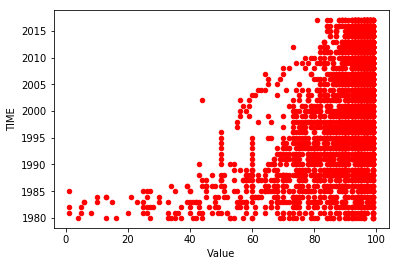

In [49]:
df_dpvax.plot(kind='scatter',x='Value',y='TIME',color='red')
plt.show()

In [50]:
df_dpvax.count()

LOCATION      3121
INDICATOR     3121
SUBJECT       3121
MEASURE       3121
FREQUENCY     3121
TIME          3121
Value         3121
Flag Codes     252
dtype: int64

In [51]:
df_dpvax['SUBJECT'].value_counts()


DTP        1572
MEASLES    1549
Name: SUBJECT, dtype: int64

In [52]:
selection2=['LOCATION','SUBJECT','Value']
df_dpvax2=pd.DataFrame(df_dpvax,columns=selection2)
df_dpvax2.head()

,LOCATION,SUBJECT,Value
0,AUS,DTP,33
1,AUS,DTP,40
2,AUS,DTP,48
3,AUS,DTP,55
4,AUS,DTP,62


In [53]:
table1=df_dpvax2.pivot(index = None, columns='SUBJECT', values = 'Value')
table1

SUBJECT,DTP,MEASLES
0,33.0,NaN
1,40.0,NaN
2,48.0,NaN
3,55.0,NaN
4,62.0,NaN
5,68.0,NaN
6,75.0,NaN
7,81.0,NaN
8,88.0,NaN
9,93.0,NaN


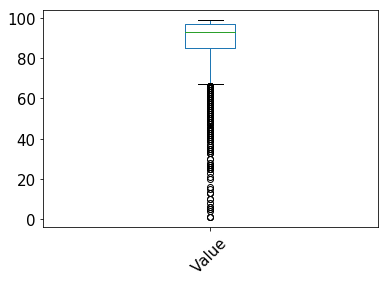

In [54]:
boxplot = df_dpvax2.boxplot(grid=False, rot=45, fontsize=15)